## Blobs in 2D Datasets Notebook

Testing my algorithms on 2D generated datasets with centers approaching together.

In [5]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy.spatial import distance

from bc_utils import TestDf

Creating datasets and saving them to pandas dataframes.

In [17]:
cluster_deviations = np.array(range(1, 7), dtype=np.float32) / 10
dataset_dfs = []
for std_deviation in cluster_deviations:
    X, y = make_blobs(n_samples=250, centers=2, cluster_std=std_deviation,
                      n_features=2) #center 1 priblizovat...
    new_dataframe = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    new_dataframe = new_dataframe
    dataset_dfs.append(new_dataframe)
    

Showing plots of the datasets.

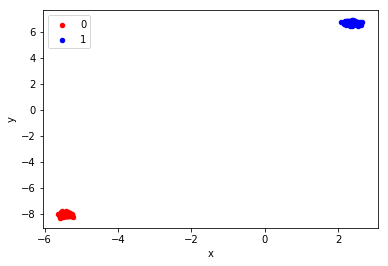

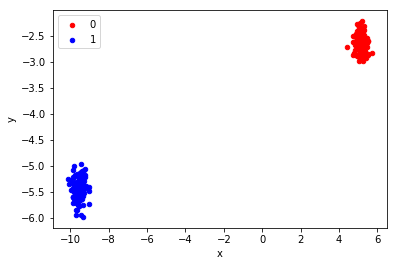

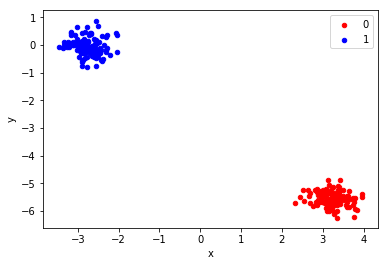

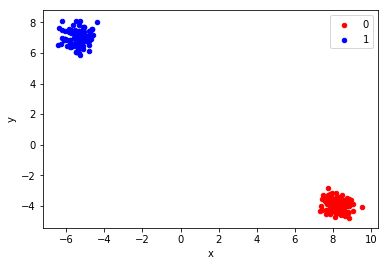

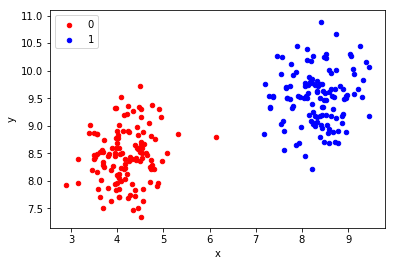

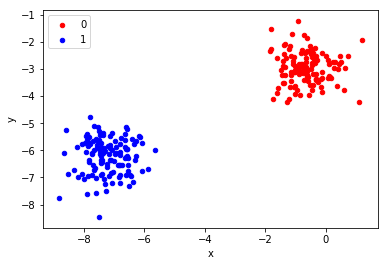

In [18]:
colors = {0:'red', 1:'blue'}
for df in dataset_dfs:
    fix, ax = pyplot.subplots()
    grouped = df.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y',
                   label=key, color=colors[key])
    pyplot.show()

Separating datasets to learn and test parts. Using own class TestDataset from utils.py

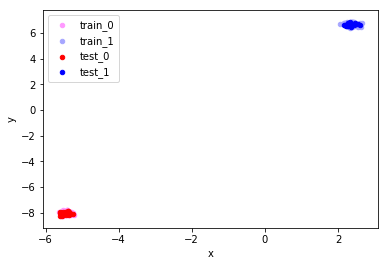

In [19]:
dataset = dataset_dfs[0]      

#creating dataset for testing algorithms
learning_dataset = TestDf(dataset)

learning_dataset.show_plot()

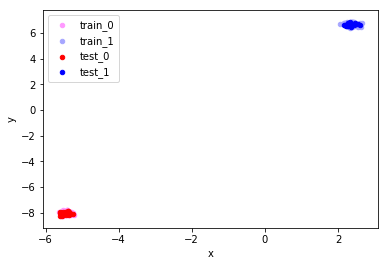

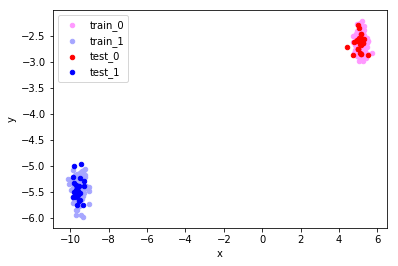

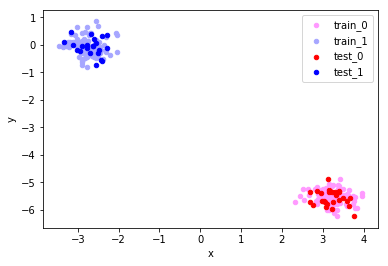

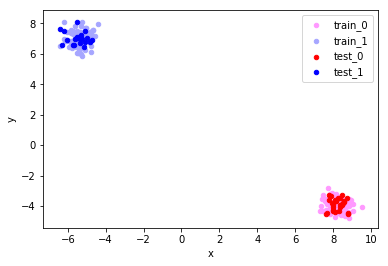

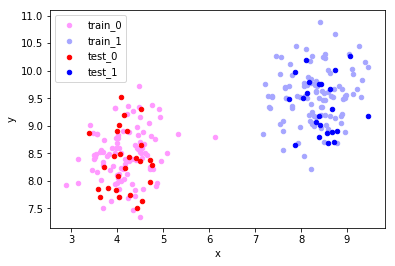

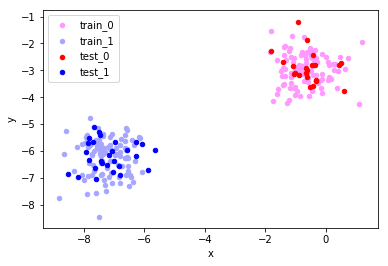

In [20]:
learning_datasets = []
for dataset in dataset_dfs:
    learning_datasets.append(TestDf(dataset))
    
for ldataset in learning_datasets:
    ldataset.show_plot()

Datagram for 0


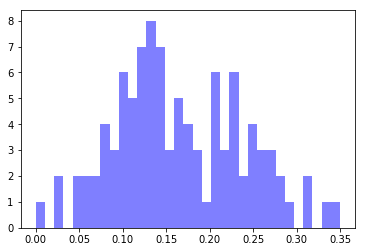

Mean distance for this dataset: 0.1646115465993132

Datagram for 1


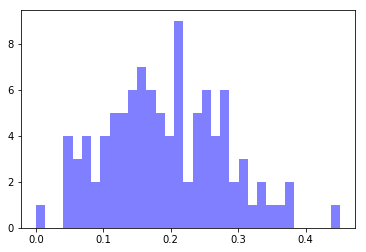

Mean distance for this dataset: 0.19151041643090708

Datagram for 0


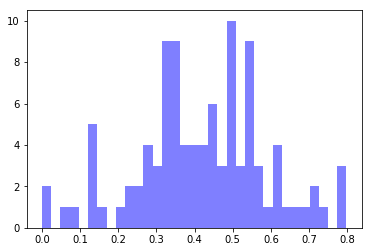

Mean distance for this dataset: 0.41865051875338677

Datagram for 1


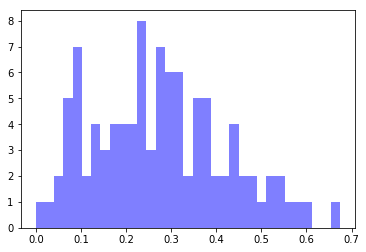

Mean distance for this dataset: 0.2761795575819246

Datagram for 0


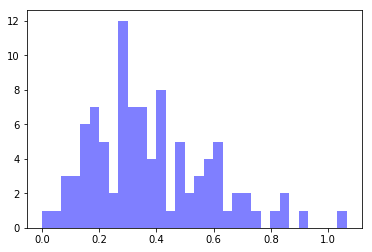

Mean distance for this dataset: 0.38160649223526444

Datagram for 1


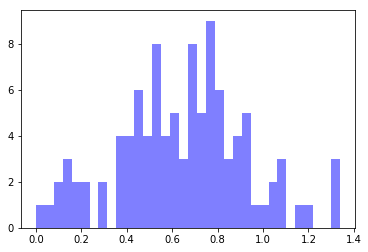

Mean distance for this dataset: 0.6479483340690018

Datagram for 0


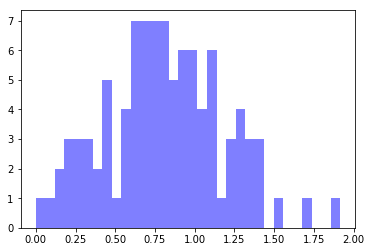

Mean distance for this dataset: 0.8110691892235679

Datagram for 1


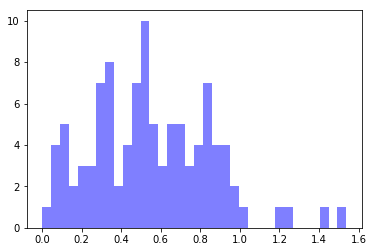

Mean distance for this dataset: 0.5503071655809815

Datagram for 0


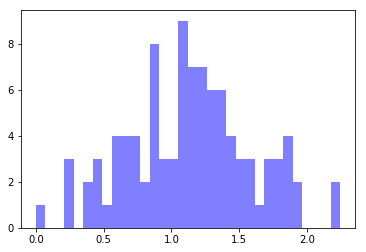

Mean distance for this dataset: 1.134430702871868

Datagram for 1


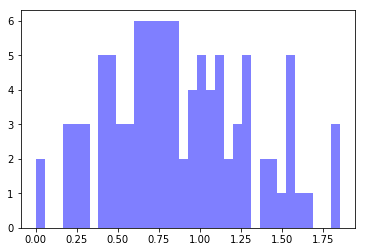

Mean distance for this dataset: 0.8667857343484112

Datagram for 0


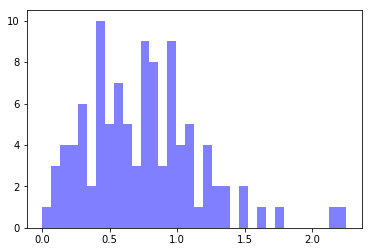

Mean distance for this dataset: 0.7441965001505992

Datagram for 1


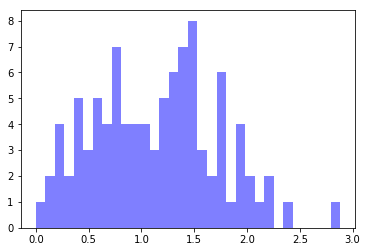

Mean distance for this dataset: 1.1377003780106312



In [21]:
# shows histograms based on distance from first point in dataset
def training_histogram(in_df):
    base_point = in_df.values[0]

    vals = in_df.values
    histogram_data = []
    for item in vals:
        histogram_data.append(distance.euclidean(
            [base_point[1], base_point[2]],
            [item[1], item[2]]))

    #for i in range(10, 60, 10):
    bins = len(histogram_data) / 3
    pyplot.hist(histogram_data, bins, facecolor='blue', alpha=0.5)
    pyplot.show()
    
    mean_distance = np.mean(histogram_data)
    print("Mean distance for this dataset: " + str(mean_distance) + "\n")
    return mean_distance

# finding representation of a cluster with random selection
# pandas.DataFrame in_df
# float delta
def randomSelection(in_df, delta):
    
    medoid_indexes = []
    index_list = list(in_df.index.values)
    
    while (index_list):
        #print("Index length: " + str(len(index_list)))
        # select first unvisited index
        ind = in_df.loc[index_list[0]].name
        #print("Selected index for this run: " + str(ind))
        ref_point = [in_df.loc[ind].values[1], in_df.loc[ind].values[2]]
        rem_indexes = []
        #print("Lenght of in_df: " + str(len(in_df)))
        
        # find indexes to drop from dataframe
        for index, row in in_df.iterrows():
            if distance.euclidean([row['x'], row['y']], ref_point) <= delta:
                rem_indexes.append(index)
        
        index_list = [item for item in index_list if item not in rem_indexes]
        #print("Droping these indexes: " + str(rem_indexes))
        rem_indexes.remove(ind)
        medoid_indexes.append(ind)
        
        in_df = in_df.drop(rem_indexes)
        #print("These indexes remain in in_df: " + str(in_df.index.values))
        
    return in_df
            

    
medoid_lst = []    
for df in learning_datasets: #[0:1]:
    
    print("Datagram for 0")
    mean_0 = training_histogram(df.train_df.loc[df.train_df["label"] == 0])
    medoid_0 = randomSelection(df.train_df.loc[df.train_df["label"] == 0], mean_0)
    
    print("Datagram for 1")
    mean_1 = training_histogram(df.train_df.loc[df.train_df["label"] == 1])
    medoid_1 = randomSelection(df.train_df.loc[df.train_df["label"] == 1], mean_1)

    medoid_lst.append([df, pd.concat([medoid_0, medoid_1])])

Moving to classify points if they fit to the right dataset by KNeighbors algorithm

In [7]:
def classifyPoints(test):

    X_train = test[0].test_df.iloc[:, 1:].values
    y_train = test[0].test_df.iloc[:, 0].values
    X_test = test[1].iloc[:, 1:].values
    y_test = test[1].iloc[:, 0].values

    from sklearn.preprocessing import StandardScaler  
    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test)

    from sklearn.neighbors import KNeighborsClassifier  
    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    from sklearn.metrics import classification_report, confusion_matrix  
    print(confusion_matrix(y_test, y_pred))  
    print(classification_report(y_test, y_pred))
    
for dataset in medoid_lst:
    classifyPoints(dataset)

[[5 0]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[6 2]
 [2 8]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.80      0.80      0.80        10

   micro avg       0.78      0.78      0.78        18
   macro avg       0.78      0.78      0.78        18
weighted avg       0.78      0.78      0.78        18

[[7 1]
 [0 6]]
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.86      1.00      0.92         6

   micro avg       0.93      0.93      0.93        14
   macro avg       0.93      0.94      0.93        14
weighted avg       0.94      